In [1]:
# HIDDEN
using CSV
using DataFrames
using LinearAlgebra
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Predicting Ice Cream Ratings

Suppose we are trying to create new, popular ice cream flavors. We are interested in the following regression problem: given the sweetness of an ice cream flavor, predict its overall taste rating out of 7.

In [2]:
ice = CSV.read("icecream.csv")

,sweetness,overall
,Float64,Float64
1,4.1,3.9
2,6.9,5.4
3,8.3,5.8
4,8.0,6.0
5,9.1,6.5
⋮,⋮,⋮


Although we expect that an ice cream flavor that is not sweet enough would receive a low rating, we also expect that an ice flavor that is too sweet would also receive a low rating. This is reflected in the scatter plot of overall rating and sweetness:

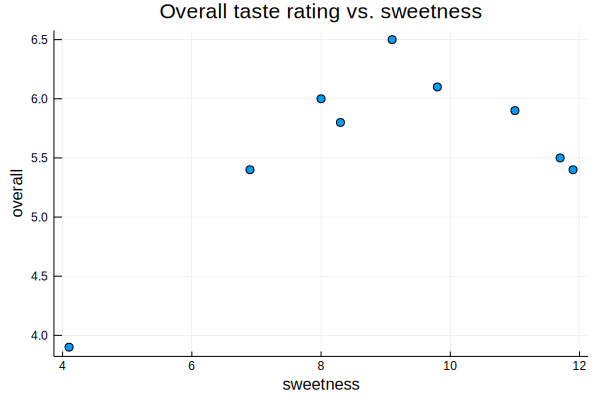

In [4]:
# HIDDEN

@df ice scatter(:sweetness, :overall, legend=false)
title!("Overall taste rating vs. sweetness")
xlabel!("sweetness")
ylabel!("overall")

Unfortunately, a linear model alone cannot take this increase-then-decrease behavior into account; in a linear model, the overall rating can only increase or decrease monotonically with the sweetness. We can see that using linear regression results in a poor fit.

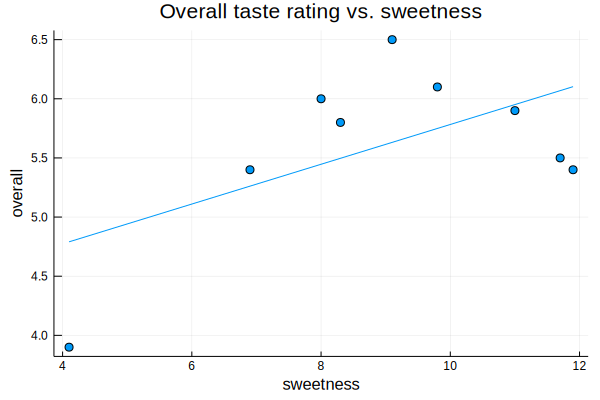

In [5]:
#HIDDEN

@df ice scatter(:sweetness, :overall, legend=false, regression=true)
title!("Overall taste rating vs. sweetness")
xlabel!("sweetness")
ylabel!("overall")

One useful approach for this problem is to fit a polynomial curve instead of line. Such a curve would allow us to model the fact that the overall rating increases with sweetness only up to a certain point, then decreases as sweetness increases.

With a feature engineering technique, we can simply add new columns to our data to use our linear model for polynomial regression.

## Polynomial Features

Recall that in linear regression we fit one weight for each column of our data matrix $ X $. In this case, our matrix $ X $ contains two columns: a column of all ones and the sweetness.

In [9]:
# HIDDEN

first_X = select(ice, :sweetness)
first_X[!, :bias] .= 1
first_X[:, [:bias, :sweetness]]

,bias,sweetness
,Int64,Float64
1,1,4.1
2,1,6.9
3,1,8.3
4,1,8.0
5,1,9.1
⋮,⋮,⋮


Our model is thus:

$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} \cdot \text{sweetness}
$$

We can create a new column in $ X $ containing the squared values of the sweetness.

In [11]:
second_X = select(first_X, [:bias, :sweetness])
second_X[!, Symbol("sweetness^2")] .= second_X.sweetness .^ 2
second_X

,bias,sweetness,sweetness^2
,Int64,Float64,Float64
1,1,4.1,16.81
2,1,6.9,47.61
3,1,8.3,68.89
4,1,8.0,64.0
5,1,9.1,82.81
⋮,⋮,⋮,⋮


Since our model learns one weight for each column of its input matrix, our model will become:

$$
f_\hat{\theta} (x) = \hat{\theta_0}
    + \hat{\theta_1} \cdot \text{sweetness}
    + \hat{\theta_2} \cdot \text{sweetness}^2
$$

Our model now fits a polynomial with degree two to our data. We can easily fit higher degree polynomials by adding columns for $ \text{sweetness}^3 $, $ \text{sweetness}^4 $, and so on.

Notice that this model is still a linear model because it is **linear in its parameters**—each $ \hat{\theta_i} $ is a scalar value of degree one. However, the model is **polynomial in its features** because its input data contains a column that is a polynomial transformation of another column.

## Polynomial Regression

To conduct polynomial regression, we use a linear model with polynomial features. We import the library [`Polynomials`](https://github.com/JuliaMath/Polynomials.jl) for conveniently transforming our dataset before loading our `LinearRegressor` model from [`MLJ`](https://alan-turing-institute.github.io/MLJ.jl/stable/).

In [12]:
using MLJ
using Polynomials

┌ Info: Recompiling stale cache file /Users/irinabchan/.julia/compiled/v1.2/MLJ/rAU56.ji for MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1240
[ Info: Model metadata loaded from registry. 


Our original data matrix $ X $ contains the following values. Remember that we include the column and row labels for reference purposes only; the actual $ X $ matrix only contains the numerical data in the table below.

In [14]:
select(ice, :sweetness)

,sweetness
,Float64
1,4.1
2,6.9
3,8.3
4,8.0
5,9.1
⋮,⋮


We create a helper function that uses `poly` to transform the data, adding polynomial features of degree 2.

In [33]:
function poly_transformer(column, degree)
    poly_matrix = Matrix(I, degree+1, degree+1)
    poly_cols = []
    for row in eachrow(poly_matrix)
        p = Poly(row)
        append!(poly_cols, [p.(column)])
    end
    return poly_cols
end;

X = DataFrame(poly_transformer(ice.sweetness, 2))
X

,x1,x2,x3
,Float64,Float64,Float64
1,1.0,4.1,16.81
2,1.0,6.9,47.61
3,1.0,8.3,68.89
4,1.0,8.0,64.0
5,1.0,9.1,82.81
⋮,⋮,⋮,⋮


Now, we fit a linear model to this data matrix.

In [34]:
#lr_model = @load LinearRegressor pkg=ScikitLearn
lr = machine(lr_model, X, ice.overall)

fit!(lr)
fitted_params(lr)

┌ Info: Training Machine{LinearRegressor} @ 5…06.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:179


(coef = [0.0, 1.6044136173072865, -0.08695689666312653],
 intercept = -1.2986259791897812,)

The parameters above show that for this dataset, the best-fit model is:

$$
f_\hat{\theta} (x) = -1.3 + 1.6 \cdot \text{sweetness} - 0.09 \cdot \text{sweetness}^2
$$

We can now compare this model's predictions against the original data.

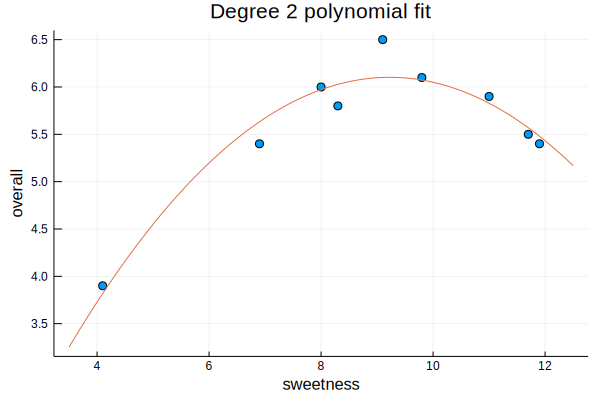

In [46]:
# HIDDEN
xs = DataFrame(poly_transformer(collect(3.5:0.001:12.5), 2))
ys = predict(lr, xs)
@df ice scatter(:sweetness, :overall, legend=false, xlabel="sweetness", ylabel="overall")
#plot!(f, 3.5:0.001:12.5, legend=false)
plot!(collect(3.5:0.001:12.5), ys, legend=false)
title!("Degree 2 polynomial fit")

This model looks like a much better fit than our linear model. We can also verify that the mean squared cost for the degree 2 polynomial fit is much lower than the cost for the linear fit.

In [70]:
# HIDDEN
using Printf
y = ice.overall

linear_X = coerce(first_X, :bias=>Continuous)
linear_lr = machine(lr_model, linear_X, y)
fit!(linear_lr)
pred_linear = predict(linear_lr, linear_X)

quad_lr = machine(lr_model, X, y)
fit!(quad_lr)
pred_quad = predict(quad_lr, X)

mse_cost(pred, y) = mean((pred .- y) .^ 2);
@printf(" MSE cost for linear reg: %0.3f\n", mse_cost(pred_linear, y))
@printf(" MSE cost for deg 2 poly reg: %0.3f\n", mse_cost(pred_quad, y))

 MSE cost for linear reg: 0.323
 MSE cost for deg 2 poly reg: 0.032


┌ Info: Training Machine{LinearRegressor} @ 6…13.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:179
┌ Info: Training Machine{LinearRegressor} @ 3…32.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:179


## Increasing the Degree

As mentioned earlier, we are free to add higher degree polynomial features to our data. For example, we can easily create polynomial features of degree 5:

In [74]:
# HIDDEN
five_X = DataFrame(poly_transformer(ice.sweetness, 5),
    [:bias, :sweetness, Symbol("sweetness^2"), Symbol("sweetness^3"), Symbol("sweetness^4"), Symbol("sweetness^5")])
five_X

,bias,sweetness,sweetness^2,sweetness^3,sweetness^4,sweetness^5
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,4.1,16.81,68.921,282.576,1158.56
2,1.0,6.9,47.61,328.509,2266.71,15640.3
3,1.0,8.3,68.89,571.787,4745.83,39390.4
4,1.0,8.0,64.0,512.0,4096.0,32768.0
5,1.0,9.1,82.81,753.571,6857.5,62403.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮


Fitting a linear model using these features results in a degree five polynomial regression.

┌ Info: Training Machine{LinearRegressor} @ 9…14.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:179


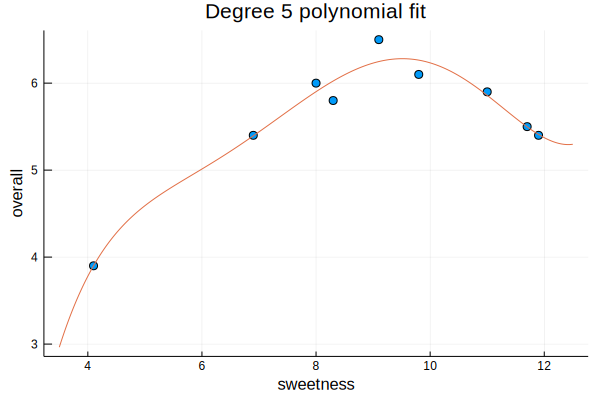

In [75]:
# HIDDEN

five_lr = machine(lr_model, five_X, y)
fit!(five_lr)

five_xs = DataFrame(poly_transformer(collect(3.5:0.001:12.5), 5))
five_ys = predict(five_lr, five_xs)
@df ice scatter(:sweetness, :overall, legend=false, xlabel="sweetness", ylabel="overall")
plot!(collect(3.5:0.001:12.5), five_ys, legend=false)
title!("Degree 5 polynomial fit")

The plot shows that a degree five polynomial seems to fit the data roughly as well as a degree two polynomial. In fact, the mean squared cost for the degree five polynomial is almost half of the cost for the degree two polynomial.

In [76]:
pred_five = predict(five_lr, five_X)

@printf(" MSE cost for linear reg: %0.3f\n", mse_cost(pred_linear, y))
@printf(" MSE cost for deg 2 poly reg: %0.3f\n", mse_cost(pred_quad, y))
@printf(" MSE cost for deg 5 poly reg: %0.3f\n", mse_cost(pred_five, y))

 MSE cost for linear reg: 0.323
 MSE cost for deg 2 poly reg: 0.032
 MSE cost for deg 5 poly reg: 0.017


This suggests that we might do even better by increasing the degree even more. Why not a degree 10 polynomial?

┌ Info: Training Machine{LinearRegressor} @ 1…98.
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:179


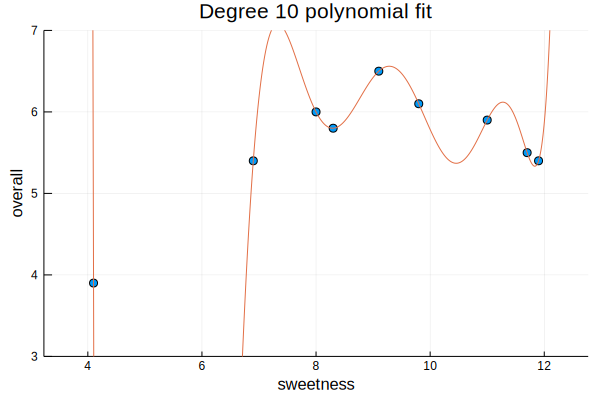

In [79]:
# HIDDEN
ten_X = DataFrame(poly_transformer(ice.sweetness, 10))

ten_lr = machine(lr_model, ten_X, y)
fit!(ten_lr)

ten_xs = DataFrame(poly_transformer(collect(3.5:0.001:12.5), 10))
ten_ys = predict(ten_lr, ten_xs)
@df ice scatter(:sweetness, :overall, legend=false, xlabel="sweetness", ylabel="overall")
plot!(collect(3.5:0.001:12.5), ten_ys, legend=false, ylim=(3, 7))
title!("Degree 10 polynomial fit")

Here are the mean squared costs for the regression models we've seen thus far:

In [80]:
# HIDDEN
pred_ten = predict(ten_lr, ten_X)

@printf(" MSE cost for linear reg: %0.3f\n", mse_cost(pred_linear, y))
@printf(" MSE cost for deg 2 poly reg: %0.3f\n", mse_cost(pred_quad, y))
@printf(" MSE cost for deg 5 poly reg: %0.3f\n", mse_cost(pred_five, y))
@printf(" MSE cost for deg 10 poly reg: %0.3f\n", mse_cost(pred_ten, y))

 MSE cost for linear reg: 0.323
 MSE cost for deg 2 poly reg: 0.032
 MSE cost for deg 5 poly reg: 0.017
 MSE cost for deg 10 poly reg: 0.000


The degree 10 polynomial has a cost of zero! This makes sense if we take a closer look at the plot; the degree ten polynomial manages to pass through the precise location of each point in the data.

However, you should feel hesitant to use the degree 10 polynomial to predict ice cream ratings. Intuitively, the degree 10 polynomial seems to fit our specific set of data too closely. If we take another set of data and plot them on the scatter plot above, we can expect that they fall close to our original set of data. When we do this, however, the degree 10 polynomial suddenly seems like a poor fit while the degree 2 polynomial still looks reasonable.

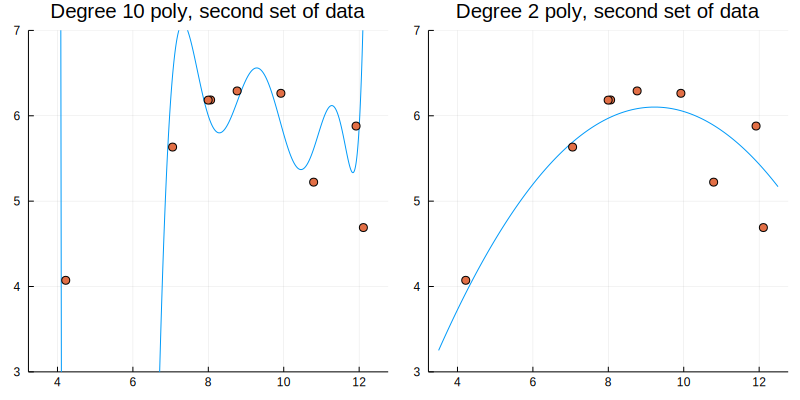

In [85]:
# HIDDEN
using Random

#Random.seed!(1)
#x_devs = randn(size(ice)[1])*0.4
#y_devs = randn(size(ice)[1])*0.4

p1 = plot(collect(3.5:0.001:12.5), ten_ys, legend=false, ylim=(3, 7), title="Degree 10 poly, second set of data")
scatter!([ice.sweetness .+ x_devs], [ice.overall .+ y_devs], legend=false)

xs = DataFrame(poly_transformer(collect(3.5:0.001:12.5), 2))
ys = predict(lr, xs)

p2 = plot(collect(3.5:0.001:12.5), ys, legend=false, ylim=(3, 7), title="Degree 2 poly, second set of data")
scatter!([ice.sweetness .+ x_devs], [ice.overall .+ y_devs], legend=false)

plot(p1,p2, size=(800,400))

We can see that in this case, degree two polynomial features work better than both no transformation and degree ten polynomial features.

This raises the natural question: in general, how do we determine which degree polynomial to fit? Although we are tempted to use the cost on the training dataset to pick the best polynomial, we have seen that using this cost can pick a model that is too complex. Instead, we want to evaluate our model on data that is not used to fit parameters.

## Summary

In this section, we introduce another feature engineering technique: adding polynomial features to the data in order to perform polynomial regression. Like one-hot encoding, adding polynomial features allows us to use our linear regression model effectively on more types of data.

We have also encountered a fundamental issue with feature engineering. Adding many features to the data gives the model a lower cost on its original set of data but often results in a less accurate model on new sets of data. 